In [2]:
import numpy as np
import random
import tensorflow as tf
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [3]:
#!pip install tf_agents

In [4]:
from numpy import tanh
from scipy.special import logit, expit, softmax
import pdb

In [5]:
class PGNNModel(object):
    '''
    Two layer neural net
    input X
    Z1 = dot(X, W1) + B1
    Z2 = tanh(Z1)
    Z3 = dot(Z2, W2) + B2
    y_hat = softmax(Z3)
    Loss(L) = cross entropy loss = -y*log(y_hat)
    
    dL/dy_hat = -1 / y_hat
    dy_hat/dZ3 = y_hat(y-y_hat)
    dZ3/dW2 = Z2
    dZ3/dB2 = 1
    dZ3/dZ2 = W2
    dZ2/dZ1 = 1 - Z2^2
    dZ1/dW1 = X
    dZ1/dB1 = 1
    
    Using chain rule
    
    dL/dW2 = (y_hat-y)*Z2
    dL/dB2 = (y_hat-y)
    
    dL/dW1 = (y_hat-y)*W2*(1-Z2^2)*X
    (input,hidden) = (1,output)*(hidden,output)*(1,hidden)*(1,input)
    
    dL/dB1 = (y_hat-y)*W2*(1-Z2^2)
    
    
    '''
    def __init__(self, ninput, nhidden, noutput):
        self.ninput_ = ninput
        self.nhidden_ = nhidden
        self.noutput_ = noutput
        #initialize model weights
        #X=(1,input)
        self.W1_ = np.random.randn(ninput, nhidden) / np.sqrt(nhidden)
        self.B1_ = np.random.randn(1, nhidden) / np.sqrt(nhidden)
        self.W2_ = np.random.randn(nhidden, noutput) / np.sqrt(noutput)
        self.B2_ = np.random.randn(1, noutput) / np.sqrt(noutput)
        
        self.dW1_cache_ = 0.
        self.dB1_cache_ = 0.
        self.dW2_cache_ = 0.
        self.dB2_cache_ = 0.
    
    def __str__(self):
        return_str = ""
        for i,j in self.__dict__.items():
            return_str += str(i) + " " + str(j) + "\n"  
        return return_str
    
    def forward(self, x):
        #x=(1,input)
        #W1=(input,hidden)
        z1 = np.dot(x, self.W1_) + self.B1_ #(1,hidden)
        z2 = tanh(z1) #(1,hidden)
        z3 = np.dot(z2, self.W2_) + self.B2_ #(1,output)
        #W2=(hidden, output)
        y_hat = softmax(z3) #(1,output)
        return y_hat, z1, z2, z3, self.W1_, self.W2_
    
    def loss(self, y, y_hat):
        eps = 1e-15
        loss = (y*-np.log(y_hat+eps)).sum()
        return loss
    
    def backward(self, x, dlogp, z1, z2, z3, w1, w2):
        #pdb.set_trace()
        #dlogp = y_hat-y
        #The reason we send dlogp is because PG method manipulates the gradient values based on reward profile
        
        dB2 = dlogp # (1, output)
        dW2 = np.dot(z2.T, dlogp) #(hidden, output)
        
        dB1 = np.dot(dlogp, w2.T)*(1-(z2*z2)) #(1,hidden)
        dW1 = np.dot(x.T, dB1) #(input,hidden)
        return dW1, dB1, dW2, dB2
            
    
    def update_SGD(self, dW1, dB1, dW2, dB2, lr=1e-4):
        self.W1_ -= lr*dW1
        self.B1_ -= lr*dB1
        self.W2_ -= lr*dW2
        self.B2_ -= lr*dB2
        
    def update_RMSProp(self, dW1, dB1, dW2, dB2, lr=1e-4):
        decay_rate = 0.9
        eps = 1e-4
        
        self.dW1_cache_ = decay_rate * self.dW1_cache_ + (1 - decay_rate) * (dW1)**2
        self.W1_ += - lr * dW1 / (np.sqrt(self.dW1_cache_) + eps)

        self.dW2_cache_ = decay_rate * self.dW2_cache_ + (1 - decay_rate) * (dW2)**2
        self.W2_ += - lr * dW2 / (np.sqrt(self.dW2_cache_) + eps)

        self.dB1_cache_ = decay_rate * self.dB1_cache_ + (1 - decay_rate) * (dB1)**2
        self.B1_ += - lr * dB1 / (np.sqrt(self.dB1_cache_) + eps)

        self.dB2_cache_ = decay_rate * self.dB2_cache_ + (1 - decay_rate) * (dB2)**2
        self.B2_ += - lr * dB2 / (np.sqrt(self.dB2_cache_) + eps)
        
        

In [6]:
def reward_disc_f(rewards):
    eps = 0.99
    rewards = [j*eps**i for i,j in enumerate(rewards)]
    rewards = [sum(rewards[i:]) for i in range(len(rewards))]
    rewards = (rewards-np.mean(rewards)) / np.std(rewards)
    return rewards

In [7]:
env_name = 'CartPole-v1'
env = suite_gym.load(env_name)

In [8]:
time_step = env.reset()
INPUT_UNITS = time_step.observation.shape[0]
HIDDEN_UNITS = 100
OUTPUT_UNITS = (env.action_spec().maximum - env.action_spec().minimum) + 1
model = PGNNModel(INPUT_UNITS, HIDDEN_UNITS, OUTPUT_UNITS)

In [9]:
num_episodes = 15000
gradient_update_after_episodes = 1
display_after = 500

episode_steps_rs = []
episode_loss_rs = []


for episode in range(num_episodes):
    episode_steps = 0
    episode_loss = 0
    
    data={}
    rms_prop_cache = {}
    episode_data = []
    rewards = []
    #discounts = []
    
    while True:
        x = time_step.observation
        x = x.reshape(1,-1)

        #discount = time_step.discount
        reward = time_step.reward

        y_hat, z1, z2, z3, w1, w2 = model.forward(x)

        #pdb.set_trace()
        #epsilon greedy agent 
        y = np.array([[1,0]]) if random.random()<y_hat[0][0] else np.array([[0,1]])

        dlogp = (y_hat - y)
        data = {'x':x, 'dlogp':dlogp, 'z1':z1, 'z2':z2, 'z3':z3, 'w1':w1, 'w2':w2}
        episode_data.append(data)

        loss = model.loss(y, y_hat)
        
        episode_loss += loss
        episode_steps += 1
        
        rewards.append(reward)
        #discounts.append(discount)

        action = np.array(0, dtype=np.int32) if y[0][0]==1 else np.array(1, dtype=np.int32)

        if time_step.is_last():

            average_episode_loss = episode_loss / episode_steps                        
            reward_disc = reward_disc_f(rewards)
            #sum up the gradients from previous episodes & update model
            dw1, db1, dw2, db2 = [0.]*4
            for i,d in enumerate(episode_data):
                dlogp = d['dlogp']*reward_disc[i]
                x = d['x']
                z1 = d['z1']
                z2 = d['z2']
                z3 = d['z3']
                w1 = d['w1']
                w2 = d['w2']
                t_dw1, t_db1, t_dw2, t_db2 = model.backward(x, dlogp, z1, z2, z3, w1, w2)
                dw1 += t_dw1
                dw2 += t_dw2
                db1 += t_db1
                db2 += t_db2
                
            #model.update_SGD(dw1, db1, dw2, db2)
            model.update_RMSProp(dw1, db1, dw2, db2)

            episode_steps_rs.append(episode_steps)
            episode_loss_rs.append(average_episode_loss)

            if ((episode+1)%display_after==0):
                episode_steps_buffer = episode_steps_rs[episode+1-display_after:episode+1]
                #print(episode_steps_buffer)
                episode_loss_buffer = episode_loss_rs[episode+1-display_after:episode+1]
                #print(episode_loss_buffer)
                min_steps = np.min(episode_steps_buffer)
                max_steps = np.max(episode_steps_buffer)
                avg_steps = np.mean(episode_steps_buffer)
                avg_loss = np.mean(episode_loss_buffer)
                print("Episode %d, Stats for previous %d episodes, max %d, min %d, avg %d steps; avg loss %f"%(episode+1, display_after, max_steps, min_steps, 
                                                                                                              avg_steps, avg_loss))
                #print(reward_disc)

            time_step = env.reset()
            break
            
        time_step = env.step(action)



Episode 500, Stats for previous 500 episodes, max 68, min 9, avg 19 steps; avg loss 0.605917
Episode 1000, Stats for previous 500 episodes, max 346, min 12, avg 88 steps; avg loss 0.642951
Episode 1500, Stats for previous 500 episodes, max 501, min 18, avg 215 steps; avg loss 0.600154
Episode 2000, Stats for previous 500 episodes, max 501, min 31, avg 255 steps; avg loss 0.579128
Episode 2500, Stats for previous 500 episodes, max 501, min 22, avg 384 steps; avg loss 0.578645
Episode 3000, Stats for previous 500 episodes, max 501, min 59, avg 435 steps; avg loss 0.569312
Episode 3500, Stats for previous 500 episodes, max 501, min 24, avg 458 steps; avg loss 0.560410
Episode 4000, Stats for previous 500 episodes, max 501, min 87, avg 464 steps; avg loss 0.560124
Episode 4500, Stats for previous 500 episodes, max 501, min 25, avg 472 steps; avg loss 0.567359
Episode 5000, Stats for previous 500 episodes, max 501, min 126, avg 481 steps; avg loss 0.570868
Episode 5500, Stats for previous 5

In [10]:
from matplotlib import pyplot as plt

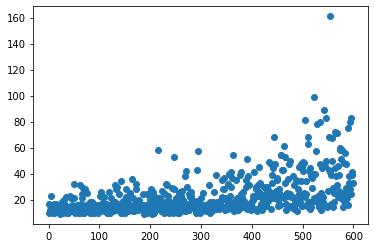

In [11]:
plt.scatter(np.array(range(len(episode_steps_rs[:600]))), episode_steps_rs[:600])

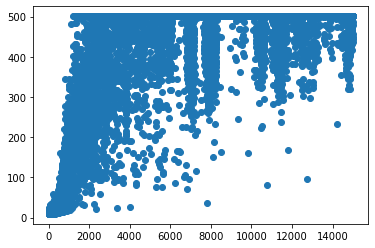

In [12]:
plt.scatter(np.array(range(len(episode_steps_rs))), episode_steps_rs)

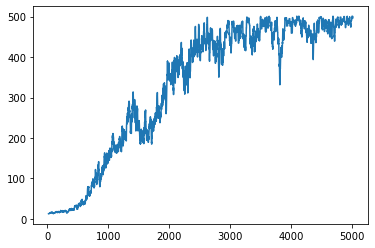

In [13]:
import pandas as pd
s1 = pd.Series(episode_steps_rs).rolling(20).mean()
s1.dropna(inplace=True)
plt.plot(s1[:5000])

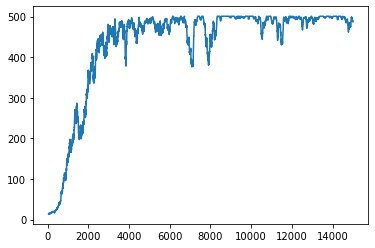

In [14]:
import pandas as pd
s2 = pd.Series(episode_steps_rs).rolling(50).mean()
s2.dropna(inplace=True)
plt.plot(s2)